In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import re

import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [5]:
tqdm.pandas()

In [6]:
zomato_orgnl = pd.read_csv('zomato.csv')

print(zomato_orgnl.shape)
zomato_orgnl.head()

(51717, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [7]:
#Deleting Unnnecessary Columns
zomato=zomato_orgnl.drop(['url','dish_liked','phone'],axis=1) 

In [8]:
#Removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

In [9]:
#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   address                      43499 non-null  object
 1   name                         43499 non-null  object
 2   online_order                 43499 non-null  object
 3   book_table                   43499 non-null  object
 4   rate                         43499 non-null  object
 5   votes                        43499 non-null  int64 
 6   location                     43499 non-null  object
 7   rest_type                    43499 non-null  object
 8   cuisines                     43499 non-null  object
 9   approx_cost(for two people)  43499 non-null  object
 10  reviews_list                 43499 non-null  object
 11  menu_item                    43499 non-null  object
 12  listed_in(type)              43499 non-null  object
 13  listed_in(city)              43

In [10]:
#Changing the Columns Names
zomato.columns
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [11]:
#Some Transformations
zomato['cost'] = zomato['cost'].astype(str)
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.'))
zomato['cost'] = zomato['cost'].astype(float)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       43499 non-null  object 
 1   name          43499 non-null  object 
 2   online_order  43499 non-null  object 
 3   book_table    43499 non-null  object 
 4   rate          43499 non-null  object 
 5   votes         43499 non-null  int64  
 6   location      43499 non-null  object 
 7   rest_type     43499 non-null  object 
 8   cuisines      43499 non-null  object 
 9   cost          43499 non-null  float64
 10  reviews_list  43499 non-null  object 
 11  menu_item     43499 non-null  object 
 12  type          43499 non-null  object 
 13  city          43499 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.0+ MB


In [12]:
# Removing '/5' from Rates
zomato = zomato.loc[zomato.rate != 'NEW']
zomato = zomato.loc[zomato.rate != '-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == str else x  # Corrected np.str to str
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')
zomato['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [13]:
df = zomato.copy()

In [14]:
all_ratings = []

for ratings in tqdm(df['reviews_list']):
    ratings = eval(ratings)
    
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            
            score = float(score)
            all_ratings.append([score, doc])

100%|███████████████████████████████████| 41237/41237 [00:07<00:00, 5422.96it/s]


In [15]:
ratings_df = pd.DataFrame(all_ratings, columns=['score', 'doc'])

print(ratings_df.shape)
ratings_df.head()

(1295849, 2)


,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


Remove ratings inside text
Some of the reviews have ratings within it. We want to train a generic model to predict ratings with only text, so we want to hide this extra information so the model does not overfit on that.
"Unhide" the output of the next cell to view sample of the ratings that contain the character "/".

In [16]:
docs_with_ratings = []
for doc in ratings_df['doc'][:150]:
    if '/' in doc:
        print(doc)
        docs_with_ratings.append(doc)

Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5
I was looking for a quite place to spend some time with family and as well wanted to try some new place. Since I was at Banashankari I thought of trying this place. The place had good rating and was part of Zomato gold. So I decided to try this place. It was a delite to see a very friendly staff and food we ordered was very tasty as well.

Food : 4/5
Ambience :3/5
Friendly staff : 4/5
Pocket friendly : 4/5

Will definitely visit again ??
Food: 8/10
Ambience:8/10
Staff:8/10
One of the good places to try north Indian food...but depends on ur taste buds. Not everyone will like all the items here. Specially when u r particular abt sweet and spicy food.
There's buffet available too.
We had ordered paneer uttar dakshin and paneer kurchan..was amazing. The Gobi hara pyaz and mix veg were average.
One of

In [17]:
print(len(docs_with_ratings))

26


We will use Regex to find and replace all the occurences of ratings.
Let's take a look at all the parts of documents that matches the pattern [0-9.]*[0-9]/[0-9]*[0-9], which correspond to any rating that has double digits (e.g. 10/10), single digits (5/5) or single digits with a fraction (e.g. 9.5/10 or 3.5/5).

In [18]:
for docs in docs_with_ratings:
    x = re.findall('[0-9.]*[0-9]/[0-9]*[0-9]', docs)
    print(x)

['5/5', '5/5', '5/5', '5/5']
['4/5', '3/5', '4/5', '4/5']
['8/10', '8/10', '8/10']
['6/10', '7/10', '8/10', '7.5/10']
[]
[]
[]
[]
['4/5', '3.5/5', '4/5', '4/5']
['3/5', '3/5', '3/5']
['10/10', '10/10', '10/10', '25/10']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4.5/5', '4/5', '4.5/5', '4.5/5']
['3.5/5', '4/5', '3.5/5']
['3.5/5', '4/5', '3.5/5']


We will replace them with the word "score", since we do not want the model to overfit on ratings that are already given in the comments.

In [19]:
doc = docs_with_ratings[0]
subbed_doc = re.sub('[0-9.]*[0-9]/[0-9]*[0-9]', 'score', doc)
print("ORIGINAL:")
print(doc)
print("\nSUBBED:")
print(subbed_doc)

ORIGINAL:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5

SUBBED:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : score
Service : score
Ambience :score
Overall :score


In [20]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


Text Processing/ Mining

In [21]:
## Lower Casing
ratings_df['review'] = ratings_df['doc'].str.lower()

In [22]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_punctuation(text))

In [23]:
ratings_df=ratings_df.drop(['doc'],axis=1) 

In [24]:
## Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_stopwords(text))
ratings_df.sample()

,score,review
881584,4.0,truffles place best burgers bangalore popular ...


In [25]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_urls(text))
ratings_df.sample(3)

,score,review
306148,5.0,want quick business meet lounge svenska best p...
378789,4.0,small place location good delicious sandwiches...
819749,4.0,zomato two plus two drink offer good ambience ...


In [26]:
ratings_df['score'].astype('category').value_counts()

4.0    397337
5.0    372425
3.0    178102
1.0    149367
2.0     65870
3.5     55691
4.5     50292
2.5     17432
1.5      9333
Name: score, dtype: int64

Clearly this is categorical data, with some heavy class imbalance. This is something to address if you want to improve performance. We will go ahead and encode that into binary labels:

In [27]:
dummies = pd.get_dummies(ratings_df['score'])
dummies.head()

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1


## Train Test Split

Finally, we split the data into train and test sets; the latter will be used to evaluate our model.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    ratings_df['review'], 
    dummies, 
    test_size=0.1, random_state=19
)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming ratings_df and other necessary variables are defined

print("Text preprocessing completed. Proceeding to vectorization...")

# Vectorize the text data
vectorizer = TfidfVectorizer()
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

print("Vectorization completed. Initializing and training the model...")

# Initialize and train the model
model = LinearRegression()
model.fit(x_train_vect, y_train)

print("Model training completed. Predicting on test data...")

# Predict on the test data
y_pred = model.predict(x_test_vect)

print("Prediction completed. Calculating R2 values...")

# Calculate R2 values
overall_r2 = r2_score(y_test, y_pred)

# Individual R2 values for each class
individual_r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print("Overall R2:", overall_r2)
print("Individual R2 for each class:", individual_r2)

Text preprocessing completed. Proceeding to vectorization...
Vectorization completed. Initializing and training the model...
Model training completed. Predicting on test data...
Prediction completed. Calculating R2 values...
Overall R2: 0.6472186404781958
Individual R2 for each class: [0.76287432 0.64996435 0.53842419 0.62102849 0.62858125 0.63423046
 0.64998104 0.62715187 0.71273181]


Epoch 1/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 398s 12ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 2/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 403s 12ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 406s 12ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 407s 12ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 5/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 404s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 1046s 32ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 7/20
32802/32802 ━━━━━━━━━━━━━━━━━━━━ 1386s 42ms/step - loss: 0

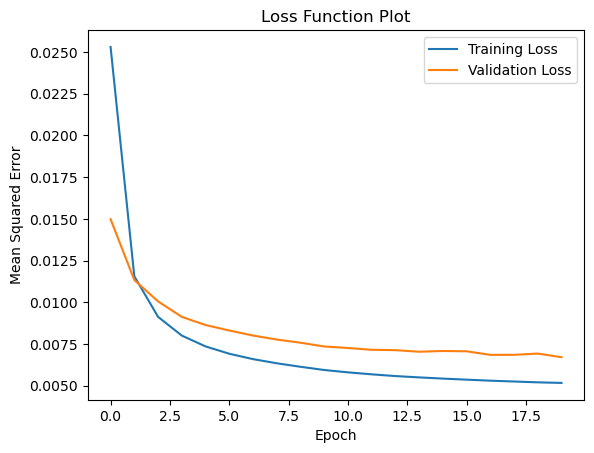

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming x_train_vect, y_train, x_test_vect, and y_test are defined

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_vect.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use Mean Squared Error as loss function
              metrics=['mean_squared_error'])

# Train the model and track the training history
history = model.fit(x_train_vect, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Plot')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [30]:
# Calculate R2 values
overall_r2 = r2_score(y_test, y_pred)

# Individual R2 values for each class
individual_r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print("Overall R2:", overall_r2)
print("Individual R2 for each class:", individual_r2)

Overall R2: 0.6472186404781958
Individual R2 for each class: [0.76287432 0.64996435 0.53842419 0.62102849 0.62858125 0.63423046
 0.64998104 0.62715187 0.71273181]
